In [1]:
from path import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import threading

scenes = [
    "SyntheticColon_I/Frames_S15",
    "SyntheticColon_I/Frames_S7",
    "SyntheticColon_I/Frames_S12",
    "SyntheticColon_I/Frames_S13",
    "SyntheticColon_I/Frames_S1",
    "SyntheticColon_I/Frames_S4",
    "SyntheticColon_I/Frames_S3",
    "SyntheticColon_I/Frames_S2",
    "SyntheticColon_I/Frames_S11",
    "SyntheticColon_I/Frames_S14",
    "SyntheticColon_I/Frames_S9",
    "SyntheticColon_I/Frames_S6",
    "SyntheticColon_I/Frames_S8",
    "SyntheticColon_I/Frames_S5",
    "SyntheticColon_I/Frames_S10",
    "SyntheticColon_II/Frames_B12",
    "SyntheticColon_II/Frames_B2",
    "SyntheticColon_II/Frames_B1",
    "SyntheticColon_II/Frames_B7",
    "SyntheticColon_II/Frames_B13",
    "SyntheticColon_II/Frames_B10",
    "SyntheticColon_II/Frames_B4",
    "SyntheticColon_II/Frames_B8",
    "SyntheticColon_II/Frames_B14",
    "SyntheticColon_II/Frames_B5",
    "SyntheticColon_II/Frames_B9",
    "SyntheticColon_II/Frames_B6",
    "SyntheticColon_II/Frames_B3",
    "SyntheticColon_II/Frames_B15",
    "SyntheticColon_II/Frames_B11",
    "SyntheticColon_III/Frames_O3",
    "SyntheticColon_III/Frames_O2",
    "SyntheticColon_III/Frames_O1",
]

In [9]:
def scroll_avg(n, cur, new_data):
    return (n-1)/n * cur + 1/n * new_data

def list_simcol_depth_files(root_path):
    files = []
    for scene in scenes:
        scene_path = root_path / scene / 'depth_gt'
        for filename in sorted(scene_path.listdir("*.npy")):
            files.append(filename)

    return files

class myThread (threading.Thread):   #继承父类threading.Thread
    def __init__(self, threadID, name, counter, files, num=1000):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.counter = counter
        self.files = files
        self.num = num
        self.value = None
    def run(self):                   #把要执行的代码写到run函数里面 线程在创建后会直接运行run函数 
        value = np.zeros_like(np.load(self.files[0])).astype(np.float128)
        for i,file in enumerate(files):
            value = scroll_avg(i+1, value, np.load(file).astype(np.float128))
        print("Done")
        self.value = value
 

def multi_thread_avg(all_files):
    # 创建 N 个线程
    # 每个线程处理 1/N 的数据
    # 每个线程处理完后，将结果返回
    # 最后将所有结果加权平均
    threads = []
    numbers = len(all_files) // 1000
    weights = []
    
    for i in range(numbers):
        thread = myThread(i, "Thread-{}".format(i), i, all_files[i*1000:(i+1)*1000])
        threads.append(thread)
        weights.append(1000.0/len(all_files))
        thread.start()
        
    threads.append(myThread(numbers, "Thread-{}".format(numbers), numbers, all_files[numbers*1000:], len(all_files)-1000*numbers))
    weights.append((len(all_files)-1000*numbers)/len(all_files))
    threads[-1].start()
    
    for t in threads:
        t.join()
    
    value = np.zeros_like(np.load(all_files[0])).astype(np.float128)
    for i in range(len(threads)):
        value += threads[i].value * weights[i]
    return value




In [3]:
root_path = Path("/home/zanxin/jiahan/SimCol3D4SC_Depth")
files = list_simcol_depth_files(root_path)
print(len(files))

/tmp/ipykernel_2116526/3931848311.py:8: DeprecationWarning: .listdir is deprecated; use iterdir
  for filename in sorted(scene_path.listdir("*.npy")):


37833


In [10]:
# 多线程计算
value = multi_thread_avg(files)

KeyboardInterrupt: 

### UCL 数据集真值深度的平均

/home/zanxin/anaconda3/envs/zx-DepthAnything-v2/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Casting input data from float128 to float64 for imshow.
  func(*args, **kwargs)
/home/zanxin/anaconda3/envs/zx-DepthAnything-v2/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


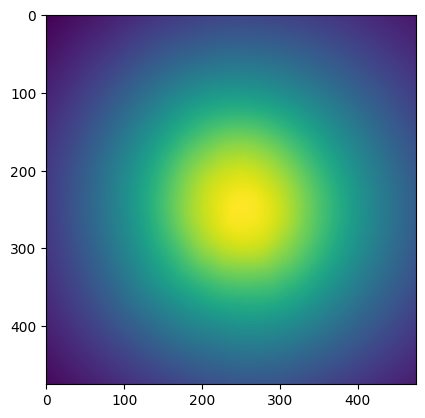

In [3]:
value = np.load("/Disk_2/ZanXin/Depth-Anything-V2/metric_depth/dataset/value.npy")
plt.imshow(value)

In [25]:
# 计算平均深度
value = np.zeros_like(np.load(files[0])).astype(np.float128)
for i, file in enumerate(tqdm(files)):

    value = scroll_avg(i+1, value, np.load(file))
    


  2%|▏         | 626/37833 [01:49<1:48:19,  5.72it/s]


KeyboardInterrupt: 

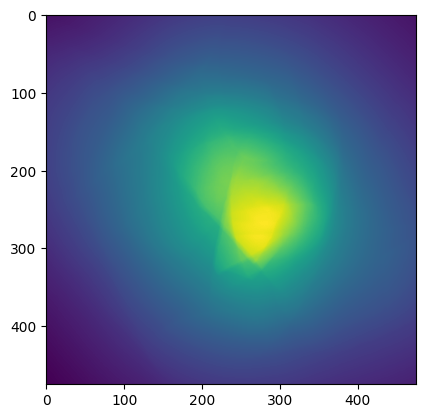

In [17]:
plt.imshow(value)